In [1]:
#Import Modules
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array,ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.optimizers import Adam

In [2]:
BASE_DIR = r"C:\Users\Shirley\Desktop\VGG16\Flickr8k"
WORKING_DIR = r"C:\Users\Shirley\Desktop\VGG16"

In [3]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [5]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [6]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [7]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [8]:
with open(os.path.join(BASE_DIR, 'Captions//captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [9]:
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [10]:
len(mapping)

8091

In [11]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [12]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [13]:
clean(mapping)

In [14]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [15]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [16]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [17]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size

8485

In [19]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

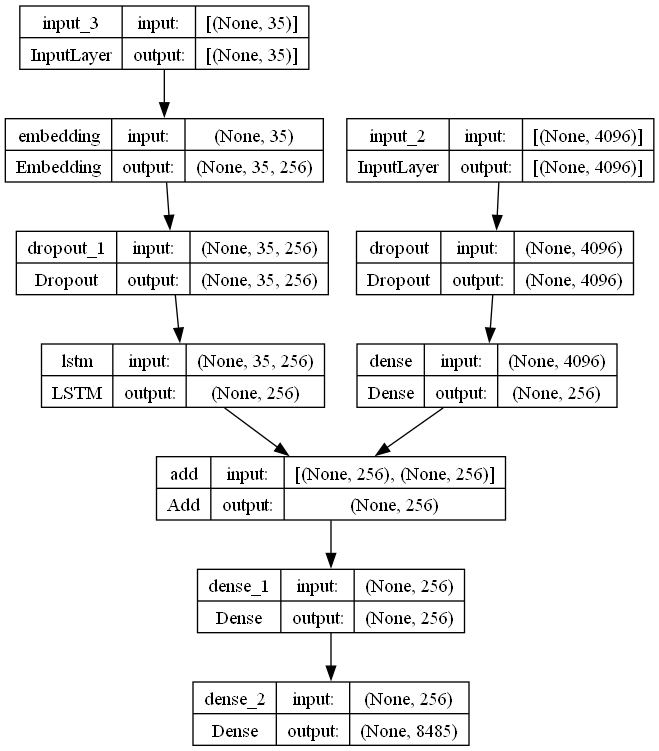

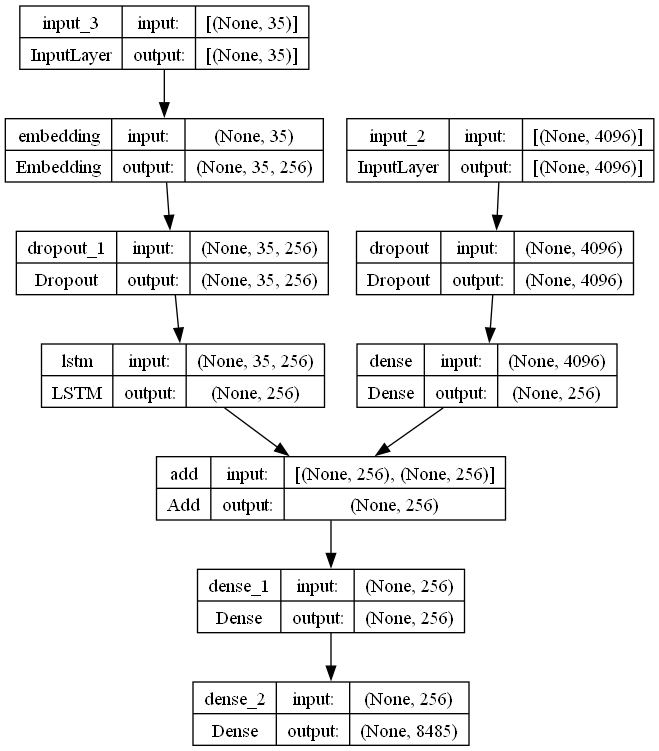

In [22]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [26]:
epochs = 30
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

113/113 [==============================] - 626s 6s/step - loss: 2.0446


In [27]:
model.save(WORKING_DIR+'/best_model.h5')

C:\Users\Shirley\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [30]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
      
    return in_text

In [35]:
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)
    
pickle.dump(actual, open(os.path.join(WORKING_DIR, 'actual.pkl'), 'wb'))
pickle.dump(predicted, open(os.path.join(WORKING_DIR, 'predicted.pkl'), 'wb'))

  0%|          | 0/810 [00:00<?, ?it/s]

In [84]:
from nltk.translate.bleu_score import corpus_bleu

def calculate_scores(actual, predicted):
    # BLEU scores
    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
    return bleu1, bleu2, bleu3, bleu4

# Load actual and predicted lists from pickle files
with open(os.path.join(WORKING_DIR, 'actual.pkl'), 'rb') as f:
    actual = pickle.load(f)
with open(os.path.join(WORKING_DIR, 'predicted.pkl'), 'rb') as f:
    predicted = pickle.load(f)
    
# Calculate the BLEU scores
bleu1, bleu2, bleu3, bleu4 = calculate_scores(actual, predicted)

# Print the BLEU scores
print("BLEU-1: %f" % bleu1)
print("BLEU-2: %f" % bleu2)
print("BLEU-3: %f" % bleu3)
print("BLEU-4: %f" % bleu4)


BLEU-1: 0.547828
BLEU-2: 0.325157
BLEU-3: 0.237476
BLEU-4: 0.122745


In [85]:
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()

reference_captions = [
    ['black', 'dog', 'and', 'spotted', 'dog', 'are', 'fighting'],
    ['black', 'dog', 'and', 'tri-colored', 'dog', 'playing', 'with', 'each', 'other', 'on', 'the', 'road'],
    ['black', 'dog', 'and', 'white', 'dog', 'with', 'brown', 'spots', 'are', 'staring', 'at', 'each', 'other', 'in', 'the', 'street'],
    ['two', 'dogs', 'of', 'different', 'breeds', 'looking', 'at', 'each', 'other', 'on', 'the', 'road'],
    ['A', 'race', 'dog', 'is', 'running', 'for', 'first']
]

candidate_caption = ['two', 'dogs', 'on', 'pavement', 'moving', 'toward', 'each', 'other']

def meteor_score(reference_captions, candidate_caption):
    precision = 0
    recall = 0
    num_matches = 0

    lemmatized_candidate = [wordnet_lemmatizer.lemmatize(word) for word in candidate_caption]

    for reference in reference_captions:
        lemmatized_reference = [wordnet_lemmatizer.lemmatize(word) for word in reference]
        for word in lemmatized_candidate:
            if word in lemmatized_reference:
                num_matches += 1
                break

    precision = num_matches / len(lemmatized_candidate)
    recall = num_matches / sum(len(reference) for reference in reference_captions)

    if precision == 0 or recall == 0:
        meteor_score = 0
    else:
        meteor_score = precision * recall / (0.9 * precision + 0.1 * recall)

    return meteor_score

meteor_score_val = meteor_score(reference_captions, candidate_caption)
print("METEOR: ", meteor_score_val)


METEOR:  0.10121457489878541


In [86]:
from pycocoevalcap.cider.cider import Cider

reference_captions = {
    '0': ['A', 'dog', 'participate', 'in', 'a', 'race', 'while', 'wear', 'the', 'number', '6']
}

# Convert the list of tokens into a single string for the predicted caption
predicted_caption_str = ' '.join(['black', 'dog', 'and', 'tri-colored', 'dog', 'playing', 'with', 'each', 'other', 'on', 'the', 'road'])
predicted_captions = {
    '0': [predicted_caption_str]
}

# Initialize the CIDEr scorer
cider_scorer = Cider()

# Compute the CIDEr score
cider_score, _ = cider_scorer.compute_score(reference_captions, predicted_captions)

print("CIDEr score:", cider_score)



CIDEr score: 0.0


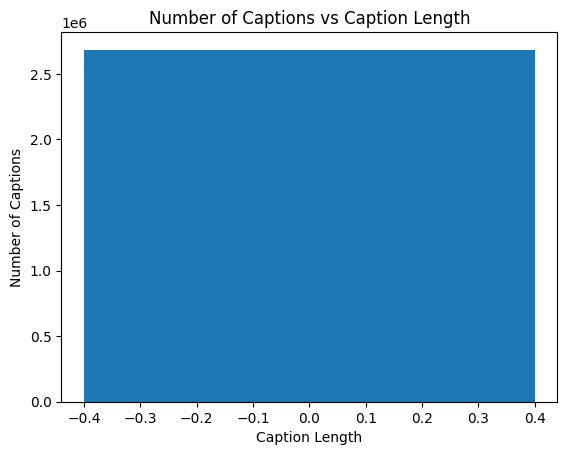

In [87]:
import matplotlib.pyplot as plt

caption_lengths = [len(caption.split()) for captions in all_captions for caption in captions]

# Plotting
plt.hist(caption_lengths, bins=range(min(caption_lengths), max(caption_lengths) + 1), align='left', rwidth=0.8)
plt.title('Number of Captions vs Caption Length')
plt.xlabel('Caption Length')
plt.ylabel('Number of Captions')
plt.show()

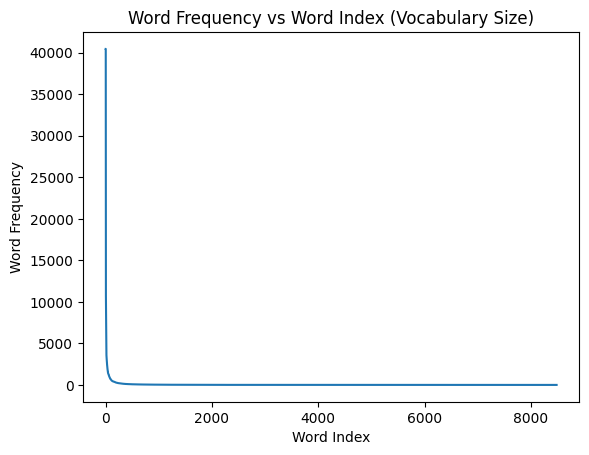

In [88]:
import matplotlib.pyplot as plt

# Convert values to a list and take only the first vocab_size values
word_freq_values = list(sorted_word_freq.values())[:vocab_size]

# Plotting
plt.plot(range(1, len(word_freq_values) + 1), word_freq_values)
plt.title('Word Frequency vs Word Index (Vocabulary Size)')
plt.xlabel('Word Index')
plt.ylabel('Word Frequency')
plt.show()



In [89]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq black and white dog is playing with white and white ball endseq


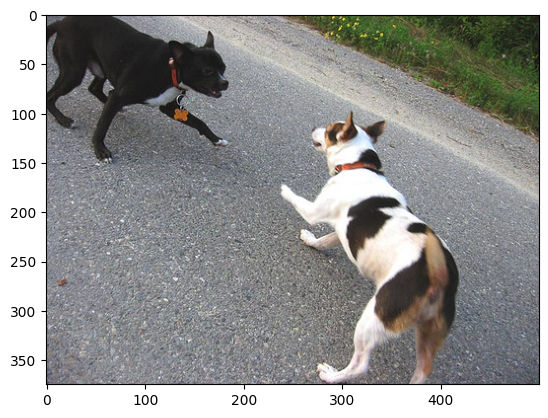

In [90]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq little girl in pigtails is sitting on the grass endseq


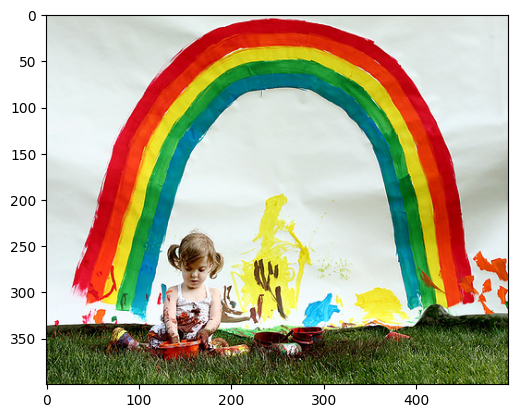

In [91]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq skier in black jacket is displaying paintings in the snow endseq


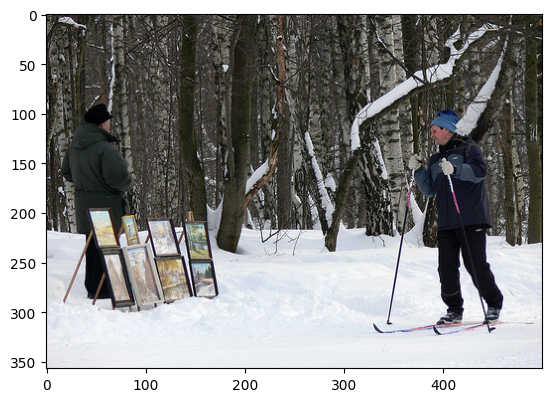

In [92]:
generate_caption("101669240_b2d3e7f17b.jpg")

In [93]:
vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [94]:
def generate_captions_for_image(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = vgg_model.predict(image, verbose=0)
    return predict_caption(model, feature, tokenizer, max_length)

In [95]:
image_path=r"C:\Users\Shirley\Downloads\cook.jpg"
generate_captions_for_image(image_path)

'startseq man in black shirt and tie is cooking food at food endseq'